In [16]:
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from src.metrics import calculate_metrics, concat_and_process_results

In [12]:
def calc_ratios(dd):
    correct = dd[dd["correct"]]
    wrong = dd[~dd["correct"]]
    correct_ratio = len(correct) / len(dd)
    wrong_ratio = len(wrong) / len(dd)
    return correct_ratio, wrong_ratio

In [13]:
base_folder = "/home/ran/afeka/computer-vision/results/2025-02-04-14-17/"
original_file = "baseline_no_rejection.csv"
experiment_file = "equal_weights.csv"
df = pd.read_csv(os.path.join(base_folder, original_file), index_col=0)

In [14]:
original_metrics = calculate_metrics(
    df=df, label_col="true_label", pred_col="prediction"
)

confidence is 0.6
17.5537109375% rejected
original: accuracy ------------ 0.7821044921875
after rejection: accuracy ---------- [0.7941585535465925]
original: precision ------------ 0.8195054945054945
after rejection: precision ---------- [0.8276972624798712]
original: recall ------------ 0.7256142057893457
after rejection: recall ---------- [0.7311522048364154]
original: f1_score ------------ 0.7697071345632821
after rejection: f1_score ---------- [0.7764350453172205]
for rejected images correct ratio: 0.7941585535465925, wrong ratio: 0.20584144645340752
for non rejected correct ratio: 0.7795380515250222, wrong ratio: 0.2204619484749778


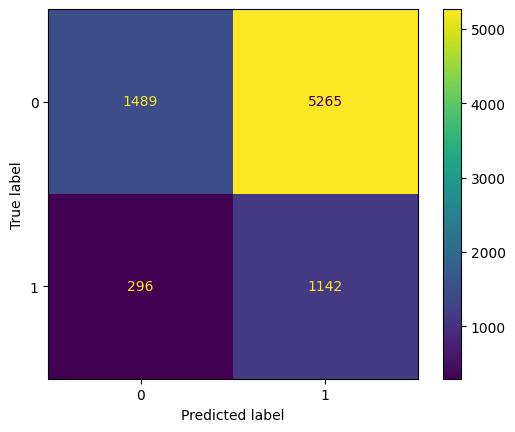

In [20]:
confidence = 0.6
print(f"confidence is {confidence}")
data = concat_and_process_results(
    base_folder, original_file, experiment_file, confidence
)
equal_metrics = calculate_metrics(
    df=data[data["rejected"]], label_col="true_label", pred_col="prediction"
)
reject_rate = len(data[data["rejected"]]) / len(data)
print(f"{reject_rate * 100}% rejected")
for key in original_metrics.keys():
    print(f"original: {key} ------------ {original_metrics[key]}")
    print(f"after rejection: {key} ---------- {[equal_metrics[key]]}")
correct_ratio, wrong_ratio = calc_ratios(dd=data[data["rejected"]])
print(f"for rejected images correct ratio: {correct_ratio}, wrong ratio: {wrong_ratio}")
correct_ratio, wrong_ratio = calc_ratios(dd=data[~data["rejected"]])
print(f"for non rejected correct ratio: {correct_ratio}, wrong ratio: {wrong_ratio}")
cm = confusion_matrix(data["rejected"], data["correct"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

confidence is 0.7
5.17578125% rejected
original: accuracy ------------ 0.7821044921875
after rejection: accuracy ---------- [0.8089622641509434]
original: precision ------------ 0.8195054945054945
after rejection: precision ---------- [0.8247422680412371]
original: recall ------------ 0.7256142057893457
after rejection: recall ---------- [0.7729468599033816]
original: f1_score ------------ 0.7697071345632821
after rejection: f1_score ---------- [0.7980049875311721]
for rejected images correct ratio: 0.8089622641509434, wrong ratio: 0.19103773584905662
for non rejected correct ratio: 0.780638516992791, wrong ratio: 0.21936148300720906


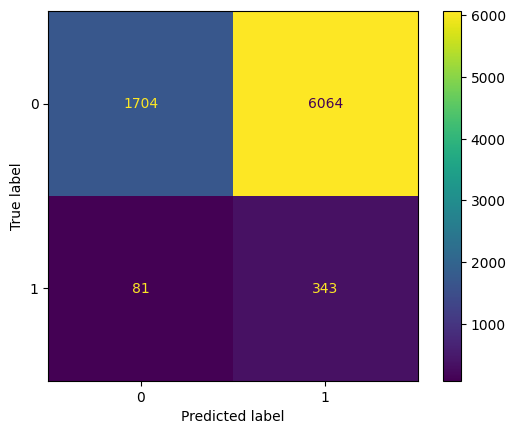

In [21]:
confidence = 0.7
print(f"confidence is {confidence}")
data = concat_and_process_results(
    base_folder, original_file, experiment_file, confidence
)
equal_metrics = calculate_metrics(
    df=data[data["rejected"]], label_col="true_label", pred_col="prediction"
)
reject_rate = len(data[data["rejected"]]) / len(data)
print(f"{reject_rate * 100}% rejected")
for key in original_metrics.keys():
    print(f"original: {key} ------------ {original_metrics[key]}")
    print(f"after rejection: {key} ---------- {[equal_metrics[key]]}")
correct_ratio, wrong_ratio = calc_ratios(dd=data[data["rejected"]])
print(f"for rejected images correct ratio: {correct_ratio}, wrong ratio: {wrong_ratio}")
correct_ratio, wrong_ratio = calc_ratios(dd=data[~data["rejected"]])
print(f"for non rejected correct ratio: {correct_ratio}, wrong ratio: {wrong_ratio}")
cm = confusion_matrix(data["rejected"], data["correct"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

confidence is 0.77
2.1240234375% rejected
original: accuracy ------------ 0.7821044921875
after rejection: accuracy ---------- [0.8045977011494253]
original: precision ------------ 0.8195054945054945
after rejection: precision ---------- [0.7407407407407407]
original: recall ------------ 0.7256142057893457
after rejection: recall ---------- [0.821917808219178]
original: f1_score ------------ 0.7697071345632821
after rejection: f1_score ---------- [0.7792207792207793]
for rejected images correct ratio: 0.8045977011494253, wrong ratio: 0.19540229885057472
for non rejected correct ratio: 0.7816163631828386, wrong ratio: 0.2183836368171614


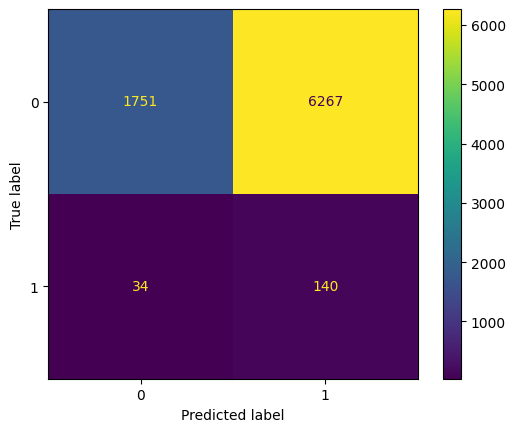

In [22]:
confidence = 0.77
print(f"confidence is {confidence}")
data = concat_and_process_results(
    base_folder, original_file, experiment_file, confidence
)
equal_metrics = calculate_metrics(
    df=data[data["rejected"]], label_col="true_label", pred_col="prediction"
)
reject_rate = len(data[data["rejected"]]) / len(data)
print(f"{reject_rate * 100}% rejected")
for key in original_metrics.keys():
    print(f"original: {key} ------------ {original_metrics[key]}")
    print(f"after rejection: {key} ---------- {[equal_metrics[key]]}")
correct_ratio, wrong_ratio = calc_ratios(dd=data[data["rejected"]])
print(f"for rejected images correct ratio: {correct_ratio}, wrong ratio: {wrong_ratio}")
correct_ratio, wrong_ratio = calc_ratios(dd=data[~data["rejected"]])
print(f"for non rejected correct ratio: {correct_ratio}, wrong ratio: {wrong_ratio}")
cm = confusion_matrix(data["rejected"], data["correct"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()